In [14]:
import sys
import os
import pickle
import numpy as np
import seaborn as sns
from transformers import (
    ViTFeatureExtractor,
    ViTModel,
    SegformerFeatureExtractor,
    SegformerModel,
)
from torch.utils.data import random_split, BatchSampler, SequentialSampler
import torch
import torchvision
import os
import shutil
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import verify_str_arg
from torchvision.datasets.utils import download_and_extract_archive
from tqdm import tqdm

home_dir = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset'
sys.path.insert(0, home_dir)
sys.path.insert(0, home_dir + "/cords")

seed = 42
device = 'cuda'
data_dir = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing'


In [15]:
def load_embeddings(pickle_name):
    """
    Load embeddings from disc
    """
    with open(pickle_name, "rb") as fIn:
        stored_data = pickle.load(fIn)
        # stored_sentences = stored_data['sentences']
        stored_embeddings = stored_data["embeddings"]
    return stored_embeddings

In [16]:
def store_embeddings(pickle_name, embeddings):
    """
    Store embeddings to disc
    """
    with open(pickle_name, "wb") as fOut:
        pickle.dump({"embeddings": embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
def compute_vit_image_embeddings(images, device, return_tensor=False):
    feature_extractor = ViTFeatureExtractor.from_pretrained(
        "google/vit-large-patch16-224-in21k"
    )
    model = ViTModel.from_pretrained("google/vit-large-patch16-224-in21k")
    model = model.to(device)
    # inputs = feature_extractor(images, return_tensors="pt")
    sampler = BatchSampler(SequentialSampler(range(len(images))), 20, drop_last=False)

    inputs = []
    for indices in tqdm(sampler, total=len(sampler), desc='pre-processing'):
        if images[0].mode == "L":
            images_batch = [images[x].convert("RGB") for x in indices]
        else:
            images_batch = [images[x] for x in indices]
        inputs.append(feature_extractor(images_batch, return_tensors="pt"))

    img_features = []
    for batch_inputs in tqdm(inputs, total=len(batch_inputs), desc='embedding'):
        tmp_feat_dict = {}
        for key in batch_inputs.keys():
            tmp_feat_dict[key] = batch_inputs[key].to(device=device)
        with torch.no_grad():
            batch_outputs = model(**tmp_feat_dict)
        batch_img_features = batch_outputs.last_hidden_state.mean(
            dim=1
        ).cpu()  # Averages over channels
        img_features.append(batch_img_features)
        del tmp_feat_dict

    img_features = torch.cat(img_features, dim=0)
    if return_tensor == False:
        return img_features.numpy()
    else:
        return img_features

In [83]:
def plot_singular_vals(embeddings, title, use_covariance = True):
    if len(embeddings.shape) == 3:
        embeddings = embeddings.reshape((embeddings.shape[0], embeddings.shape[1]**2))
    if use_covariance == True:
        cov = np.cov(embeddings, rowvar=False)
        U, s, V = np.linalg.svd(cov)
    else:
        U, s, V = np.linalg.svd(embeddings)
    plt = sns.scatterplot(np.log(s))
    plt.set_title(title)
    plt.set_xlabel('Singular Value Rank Index')
    plt.set_ylabel('Log of Singular Value')

# Pascal ViT

In [44]:
pascal_embeddings_path = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing/pascal_ctx_ViT_train_embeddings.pkl'
pascal_embeddings = load_embeddings(pascal_embeddings_path)

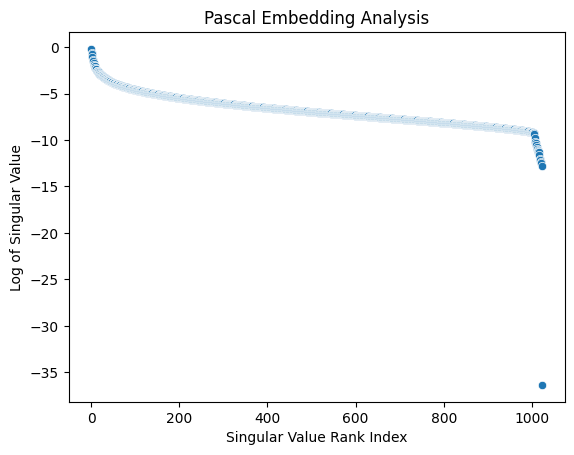

In [45]:
plot_singular_vals(pascal_embeddings, 'Pascal Embedding Analysis')

# CIFAR 10

In [19]:
cifar10_emb_path = os.path.join(
        os.path.abspath(data_dir),
        'cifar10' + "_" + 'ViT' + "_train_embeddings.pkl",
    )
if os.path.exists(cifar10_emb_path):
    cifar10_embeddings = load_embeddings(cifar10_emb_path)
else:
    fullset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=None
    )
    validation_set_fraction = 0.1
    num_fulltrn = len(fullset)
    num_val = int(num_fulltrn * validation_set_fraction)
    num_trn = num_fulltrn - num_val
    trainset, valset = random_split(
        fullset, [num_trn, num_val], generator=torch.Generator().manual_seed(seed)
    )

    images = [x[0] for x in trainset]
    cifar10_embeddings = compute_vit_image_embeddings(images, device, return_tensor=False)
    store_embeddings(cifar10_emb_path
        ,
        cifar10_embeddings,
    )

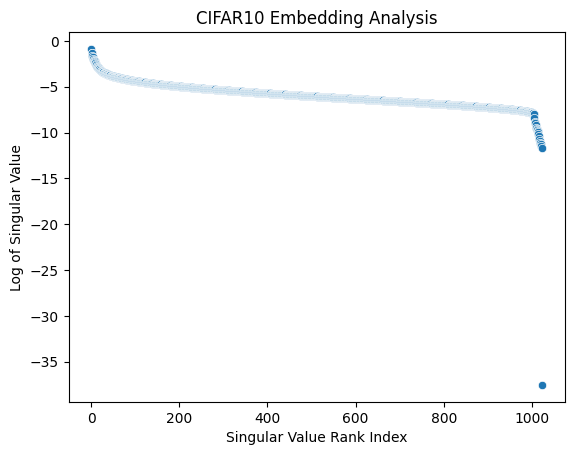

In [20]:
plot_singular_vals(cifar10_embeddings, 'CIFAR10 Embedding Analysis')

# CIFAR 100

In [21]:
cifar100_emb_path = os.path.join(
        os.path.abspath(data_dir),
        'cifar100' + "_" + 'ViT' + "_train_embeddings.pkl",
    )
if os.path.exists(cifar100_emb_path):
    cifar100_embeddings = load_embeddings(cifar100_emb_path)
else:
    fullset = torchvision.datasets.CIFAR100(
    root=data_dir, train=True, download=True, transform=None
    )
    validation_set_fraction = 0.1
    num_fulltrn = len(fullset)
    num_val = int(num_fulltrn * validation_set_fraction)
    num_trn = num_fulltrn - num_val
    trainset, valset = random_split(
        fullset, [num_trn, num_val], generator=torch.Generator().manual_seed(seed)
    )
    
    images = [x[0] for x in trainset]
    cifar100_embeddings = compute_vit_image_embeddings(images, device, return_tensor=False)
    store_embeddings(cifar100_emb_path
        ,
        cifar100_embeddings,
    )

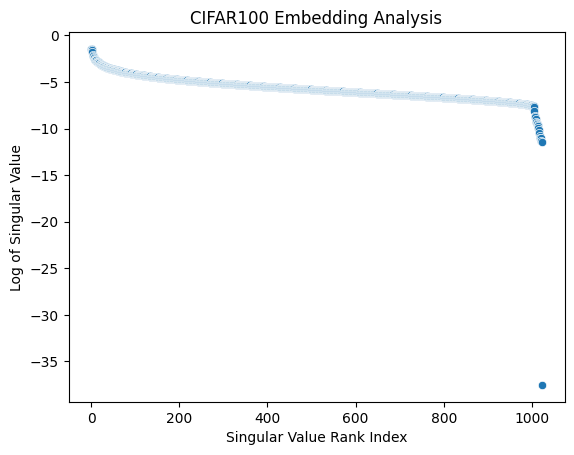

In [22]:
plot_singular_vals(cifar100_embeddings, 'CIFAR100 Embedding Analysis')

# Tiny ImageNet

In [6]:
def normalize_tin_val_folder_structure(path,
                                       images_folder='images',
                                       annotations_file='val_annotations.txt'):
    # Check if files/annotations are still there to see
    # if we already run reorganize the folder structure.
    images_folder = os.path.join(path, images_folder)
    annotations_file = os.path.join(path, annotations_file)

    # Exists
    if not os.path.exists(images_folder) \
       and not os.path.exists(annotations_file):
        if not os.listdir(path):
            raise RuntimeError('Validation folder is empty.')
        return

    # Parse the annotations
    with open(annotations_file) as f:
        for line in f:
            values = line.split()
            img = values[0]
            label = values[1]
            img_file = os.path.join(images_folder, values[0])
            label_folder = os.path.join(path, label)
            os.makedirs(label_folder, exist_ok=True)
            try:
                shutil.move(img_file, os.path.join(label_folder, img))
            except FileNotFoundError:
                continue

    os.sync()
    assert not os.listdir(images_folder)
    shutil.rmtree(images_folder)
    os.remove(annotations_file)
    os.sync()

In [7]:
class TinyImageNet(ImageFolder):
    """Dataset for TinyImageNet-200"""
    base_folder = 'tiny-imagenet-200'
    zip_md5 = '90528d7ca1a48142e341f4ef8d21d0de'
    splits = ('train', 'val')
    filename = 'tiny-imagenet-200.zip'
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

    def __init__(self, root, split='train', download=False, **kwargs):
        self.data_root = os.path.expanduser(root)
        self.split = verify_str_arg(split, "split", self.splits)

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        super().__init__(self.split_folder, **kwargs)

    @property
    def dataset_folder(self):
        return os.path.join(self.data_root, self.base_folder)

    @property
    def split_folder(self):
        return os.path.join(self.dataset_folder, self.split)

    def _check_exists(self):
        return os.path.exists(self.split_folder)

    def extra_repr(self):
        return "Split: {split}".format(**self.__dict__)

    def download(self):
        if self._check_exists():
            return
        download_and_extract_archive(
            self.url, self.data_root, filename=self.filename,
            remove_finished=True, md5=self.zip_md5)
        assert 'val' in self.splits
        normalize_tin_val_folder_structure(
            os.path.join(self.dataset_folder, 'val'))

In [10]:
def compute_vit_image_embeddings(images, device, return_tensor=False):
    feature_extractor = ViTFeatureExtractor.from_pretrained(
        "google/vit-large-patch16-224-in21k"
    )
    model = ViTModel.from_pretrained("google/vit-large-patch16-224-in21k")
    model = model.to(device)
    # inputs = feature_extractor(images, return_tensors="pt")
    sampler = BatchSampler(SequentialSampler(range(len(images))), 20, drop_last=False)
    img_features = []

    for indices in tqdm(sampler, total=len(sampler), desc='embedding'):
        if images[0].mode == "L":
            images_batch = [images[x].convert("RGB") for x in indices]
        else:
            images_batch = [images[x] for x in indices]
        batch_inputs = feature_extractor(images_batch, return_tensors="pt")
        tmp_feat_dict = {}
        for key in batch_inputs.keys():
            tmp_feat_dict[key] = batch_inputs[key].to(device=device)
        with torch.no_grad():
            batch_outputs = model(**tmp_feat_dict)
        batch_img_features = batch_outputs.last_hidden_state.mean(
            dim=1
        ).cpu()  # Averages over channels
        img_features.append(batch_img_features)
        del tmp_feat_dict

    img_features = torch.cat(img_features, dim=0)
    if return_tensor == False:
        return img_features.numpy()
    else:
        return img_features

In [24]:
tinyImageNet_emb_path = os.path.join(
        os.path.abspath(data_dir),
        'tinyImageNet' + "_" + 'ViT' + "_train_embeddings.pkl",
    )
if os.path.exists(tinyImageNet_emb_path):
    tinyImageNet_embeddings = load_embeddings(tinyImageNet_emb_path)
else:
    fullset = TinyImageNet(
    root=data_dir, split="train", download=True, transform=None
    )
    validation_set_fraction = 0.1
    num_fulltrn = len(fullset)
    num_val = int(num_fulltrn * validation_set_fraction)
    num_trn = num_fulltrn - num_val
    trainset, valset = random_split(
        fullset, [num_trn, num_val], generator=torch.Generator().manual_seed(seed)
    )
    
    images = [x[0] for x in trainset]
    print('here')
    tinyImageNet_embeddings = compute_vit_image_embeddings(images, device, return_tensor=False)
    store_embeddings(tinyImageNet_emb_path
        ,
        tinyImageNet_embeddings,
    )

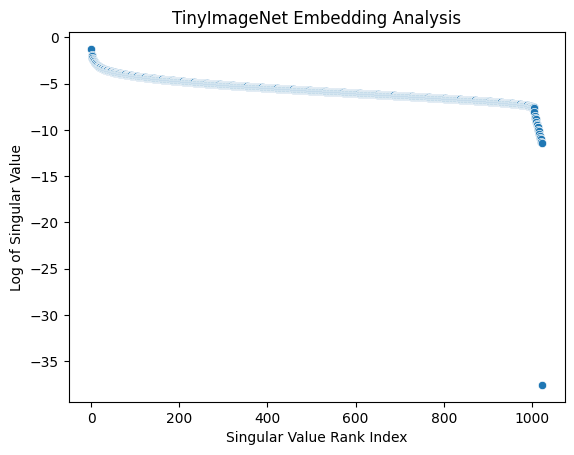

In [25]:
plot_singular_vals(tinyImageNet_embeddings, 'TinyImageNet Embedding Analysis')

# Pascal Segformer

In [81]:
pascal_sf_embeddings_path = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing/pascal_ctx_segformer_train_embeddings.pkl'
pascal_sf_embeddings = load_embeddings(pascal_sf_embeddings_path)

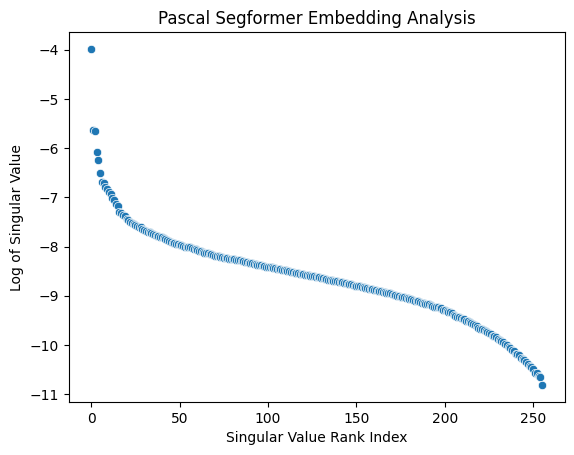

In [84]:
plot_singular_vals(pascal_sf_embeddings, 'Pascal Segformer Embedding Analysis')

# Pascal Oracle Spat

In [87]:
pascal_os_embeddings_path = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing/pascal_ctx_oracle_spat_train_embeddings.pkl'
pascal_os_embeddings = load_embeddings(pascal_os_embeddings_path)

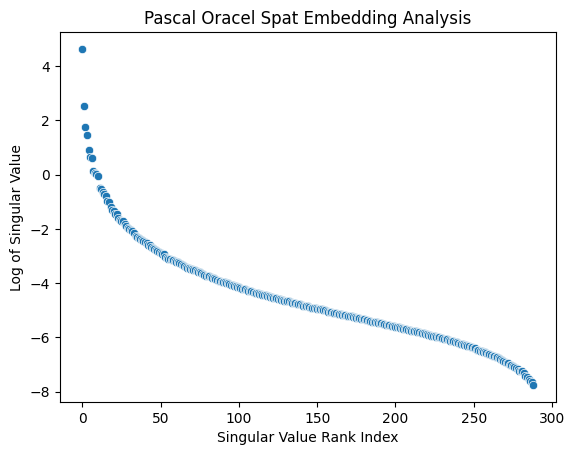

In [88]:
plot_singular_vals(pascal_os_embeddings, 'Pascal Oracel Spat Embedding Analysis')

# Pascal Oracle Context

In [89]:
pascal_oc_embeddings_path = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing/pascal_ctx_oracle_context_train_embeddings.pkl'
pascal_oc_embeddings = load_embeddings(pascal_oc_embeddings_path)

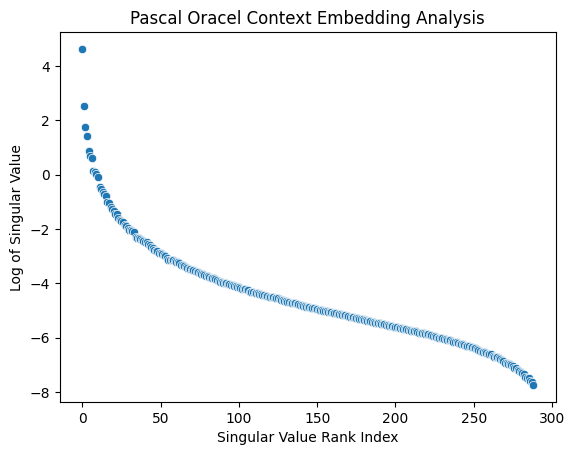

In [90]:
plot_singular_vals(pascal_oc_embeddings, 'Pascal Oracel Context Embedding Analysis')